In [ ]:
"""
Path planning Sample Code with RRT with path smoothing
@author: AtsushiSakai(@Atsushi_twi)
"""

import math
import os
import random
import sys
import numpy as np
import random

from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.pyplot as plt

show_animation = True  


In [ ]:
class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=3.0,
                 path_resolution=0.5,
                 goal_sample_rate=5,
                 max_iter=500):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []

    def planning(self, animation=True):
        """
        rrt path planning
        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_collision(new_node, self.obstacle_list):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(final_node, self.obstacle_list):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                random.uniform(self.min_rand, self.max_rand),
                random.uniform(self.min_rand, self.max_rand))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([-2, 15, -2, 15])
        plt.grid(True)
        plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_collision(node, obstacleList):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= size**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta

In [ ]:
class RRTStar(RRT):
    """
    Class for RRT Star planning
    """

    class Node(RRT.Node):
        def __init__(self, x, y):
            super().__init__(x, y)
            self.cost = 0.0

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=30.0,
                 path_resolution=1.0,
                 goal_sample_rate=20,
                 max_iter=300,
                 connect_circle_dist=50.0,
                 search_until_max_iter=False):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        """
        super().__init__(start, goal, obstacle_list, rand_area, expand_dis,
                         path_resolution, goal_sample_rate, max_iter)
        self.connect_circle_dist = connect_circle_dist
        self.goal_node = self.Node(goal[0], goal[1])
        self.search_until_max_iter = search_until_max_iter

    def planning(self, animation=True):
        """
        rrt star path planning
        animation: flag for animation on or off .
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)
            new_node = self.steer(self.node_list[nearest_ind], rnd,
                                  self.expand_dis)
            near_node = self.node_list[nearest_ind]
            new_node.cost = near_node.cost + \
                math.hypot(new_node.x-near_node.x,
                           new_node.y-near_node.y)

            if self.check_collision(new_node, self.obstacle_list):
                near_inds = self.find_near_nodes(new_node)
                node_with_updated_parent = self.choose_parent(
                    new_node, near_inds)
                if node_with_updated_parent:
                    self.rewire(node_with_updated_parent, near_inds)
                    self.node_list.append(node_with_updated_parent)
                else:
                    self.node_list.append(new_node)

            if animation:
                self.draw_graph(rnd)

            if ((not self.search_until_max_iter)
                    and new_node):  # if reaches goal
                last_index = self.search_best_goal_node()
                if last_index is not None:
                    return self.generate_final_course(last_index)

        print("reached max iteration")

        last_index = self.search_best_goal_node()
        if last_index is not None:
            return self.generate_final_course(last_index)

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and th tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node
            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:
            near_node = self.node_list[i]
            t_node = self.steer(near_node, new_node)
            if t_node and self.check_collision(t_node, self.obstacle_list):
                costs.append(self.calc_new_cost(near_node, new_node))
            else:
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]
        new_node = self.steer(self.node_list[min_ind], new_node)
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):
        dist_to_goal_list = [
            self.calc_dist_to_goal(n.x, n.y) for n in self.node_list
        ]
        goal_inds = [
            dist_to_goal_list.index(i) for i in dist_to_goal_list
            if i <= self.expand_dis
        ]

        safe_goal_inds = []
        for goal_ind in goal_inds:
            t_node = self.steer(self.node_list[goal_ind], self.goal_node)
            if self.check_collision(t_node, self.obstacle_list):
                safe_goal_inds.append(goal_ind)

        if not safe_goal_inds:
            return None

        min_cost = min([self.node_list[i].cost for i in safe_goal_inds])
        for i in safe_goal_inds:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """
        1) defines a ball centered on new_node
        2) Returns all nodes of the three that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * math.sqrt((math.log(nnode) / nnode))
        # if expand_dist exists, search vertices in a range no more than
        # expand_dist
        if hasattr(self, 'expand_dis'):
            r = min(r, self.expand_dis)
        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree
                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.
        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(edge_node, self.obstacle_list)
            improved_cost = near_node.cost > edge_node.cost

            if no_collision and improved_cost:
                near_node.x = edge_node.x
                near_node.y = edge_node.y
                near_node.cost = edge_node.cost
                near_node.path_x = edge_node.path_x
                near_node.path_y = edge_node.path_y
                near_node.parent = edge_node.parent
                self.propagate_cost_to_leaves(new_node)

    def calc_new_cost(self, from_node, to_node):
        d, _ = self.calc_distance_and_angle(from_node, to_node)
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)

In [ ]:
1def get_path_length(path):
    le = 0
    for i in range(len(path) - 1):
        dx = path[i + 1][0] - path[i][0]
        dy = path[i + 1][1] - path[i][1]
        d = math.sqrt(dx * dx + dy * dy)
        le += d

    return le


def get_target_point(path, targetL):
    le = 0
    ti = 0
    lastPairLen = 0
    for i in range(len(path) - 1):
        dx = path[i + 1][0] - path[i][0]
        dy = path[i + 1][1] - path[i][1]
        d = math.sqrt(dx * dx + dy * dy)
        le += d
        if le >= targetL:
            ti = i - 1
            lastPairLen = d
            break

    partRatio = (le - targetL) / lastPairLen

    x = path[ti][0] + (path[ti + 1][0] - path[ti][0]) * partRatio
    y = path[ti][1] + (path[ti + 1][1] - path[ti][1]) * partRatio

    return [x, y, ti]


def line_collision_check(first, second, obstacleList):
    # Line Equation

    x1 = first[0]
    y1 = first[1]
    x2 = second[0]
    y2 = second[1]

    try:
        a = y2 - y1
        b = -(x2 - x1)
        c = y2 * (x2 - x1) - x2 * (y2 - y1)
    except ZeroDivisionError:
        return False

    for (ox, oy, size) in obstacleList:
        d = abs(a * ox + b * oy + c) / (math.sqrt(a * a + b * b))
        if d <= size:
            return False

    return True  # OK


def path_smoothing(path, max_iter, obstacle_list):
    le = get_path_length(path)

    for i in range(max_iter):
        # Sample two points
        pickPoints = [random.uniform(0, le), random.uniform(0, le)]
        pickPoints.sort()
        first = get_target_point(path, pickPoints[0])
        second = get_target_point(path, pickPoints[1])

        if first[2] <= 0 or second[2] <= 0:
            continue

        if (second[2] + 1) > len(path):
            continue

        if second[2] == first[2]:
            continue

        # collision check
        if not line_collision_check(first, second, obstacle_list):
            continue

        # Create New path
        newPath = []
        newPath.extend(path[:first[2] + 1])
        newPath.append([first[0], first[1]])
        newPath.append([second[0], second[1]])
        newPath.extend(path[second[2] + 1:])
        path = newPath
        le = get_path_length(path)

    return path

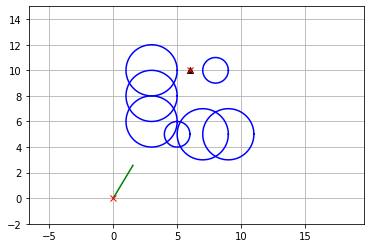

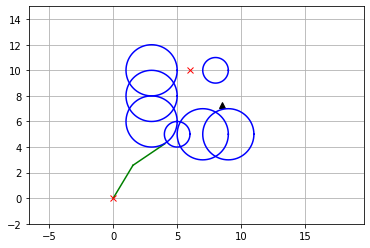

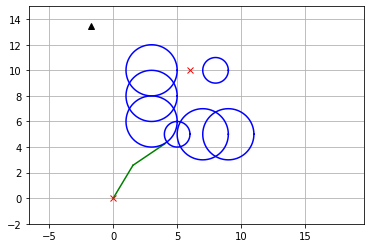

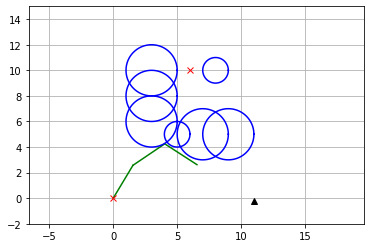

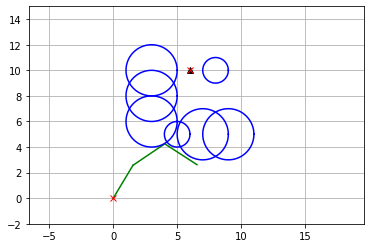

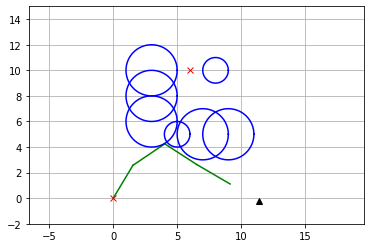

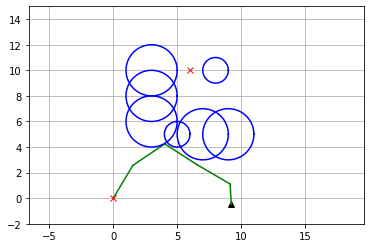

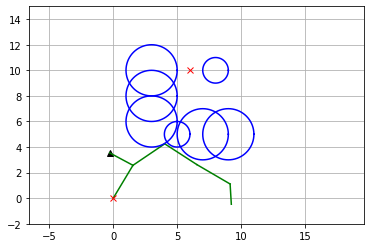

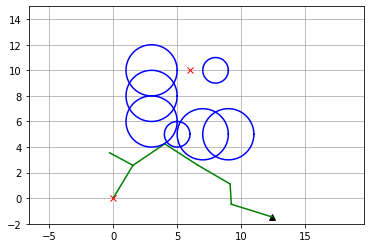

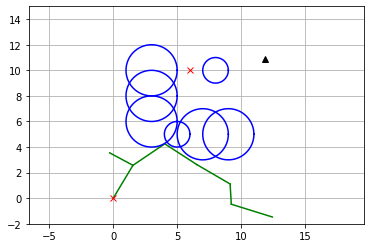

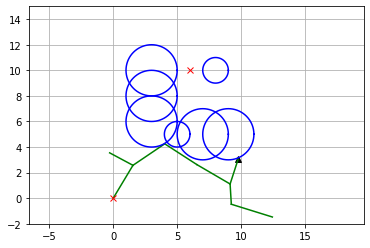

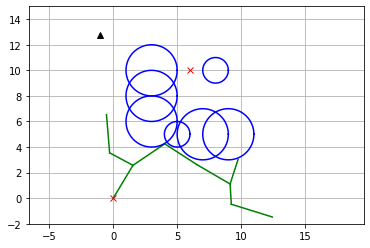

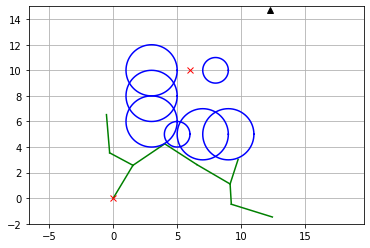

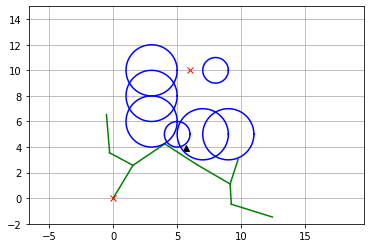

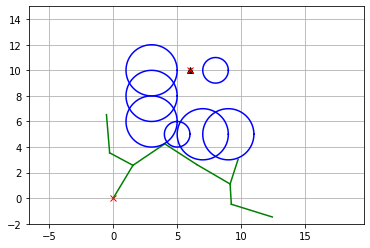

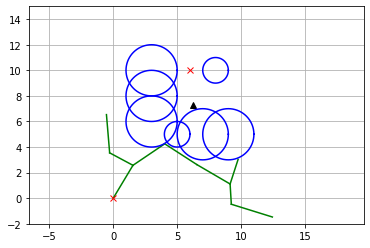

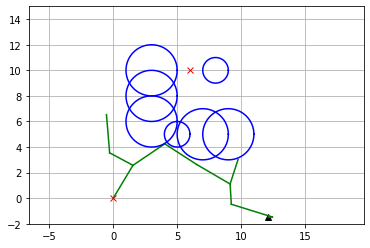

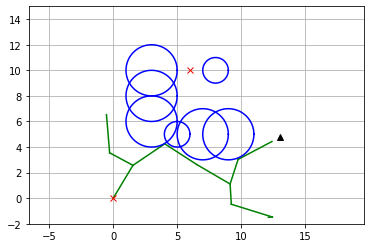

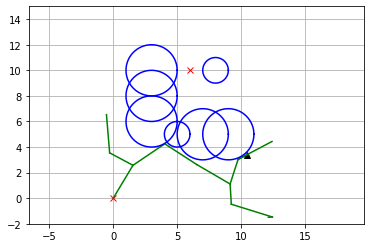

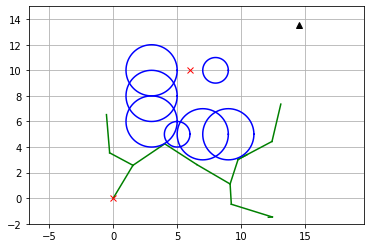

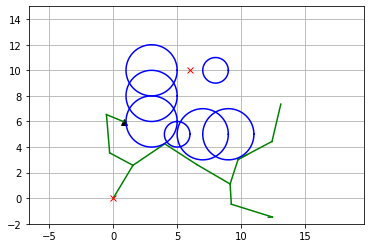

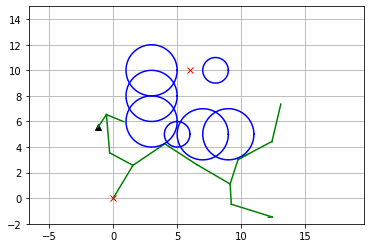

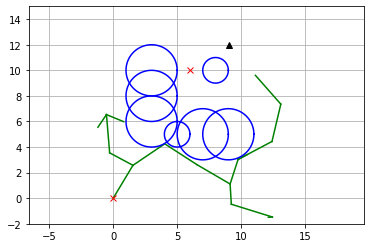

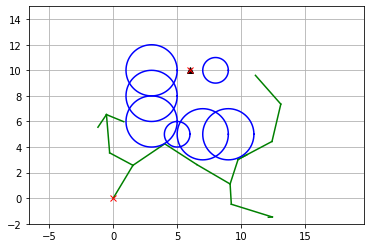

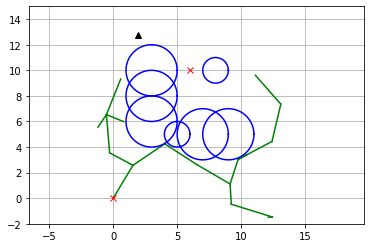

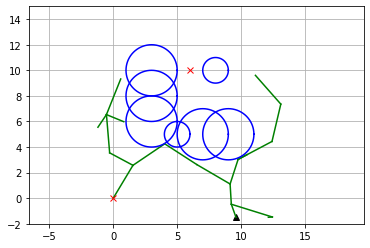

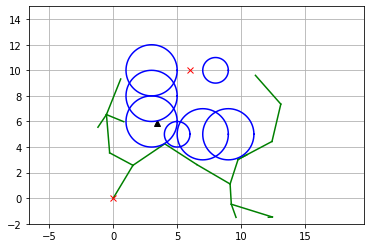

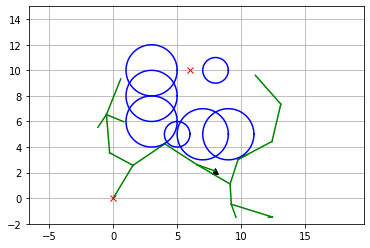

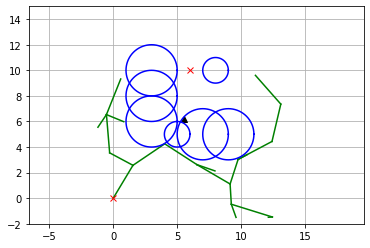

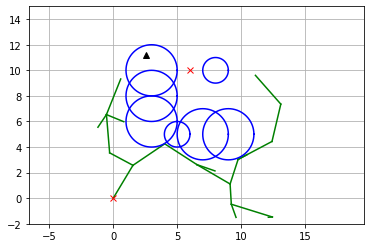

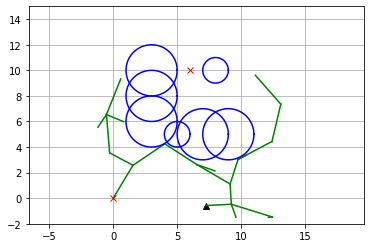

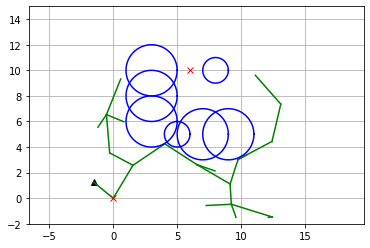

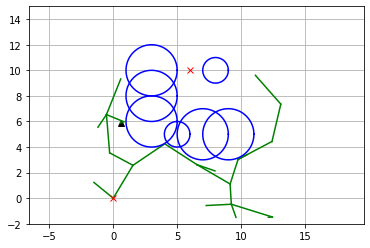

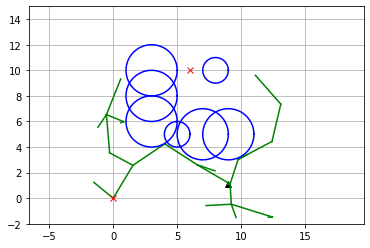

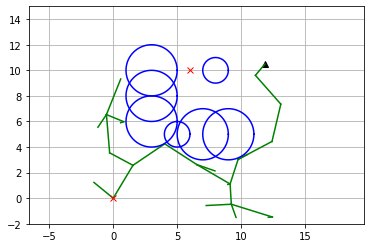

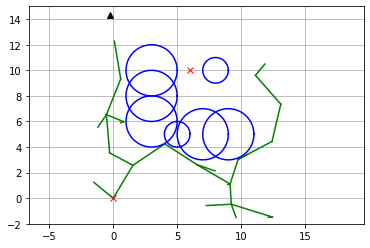

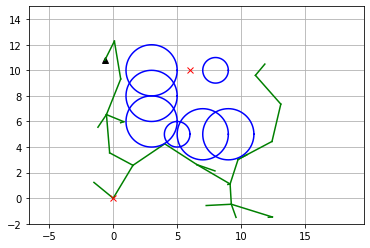

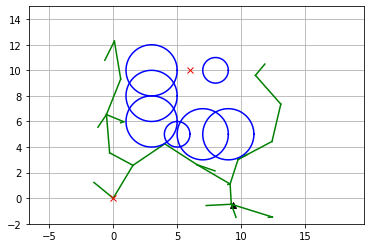

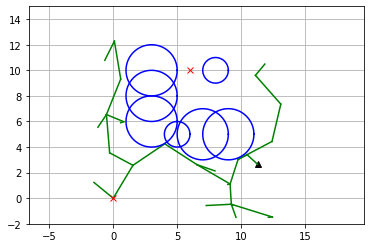

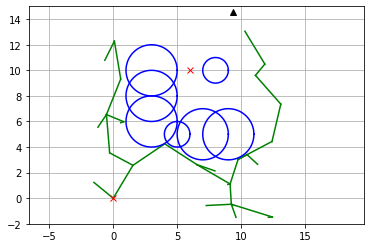

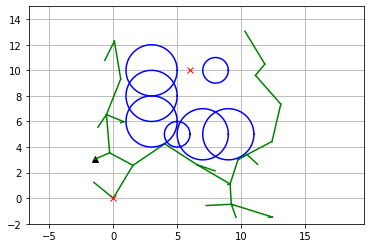

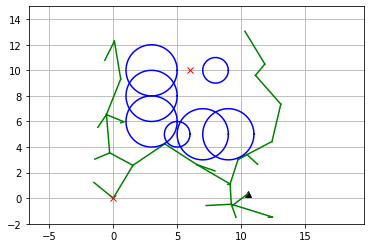

found path!!


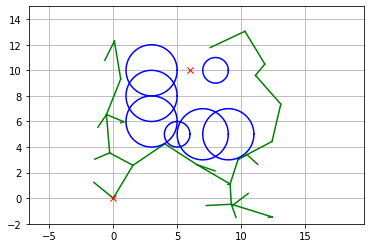

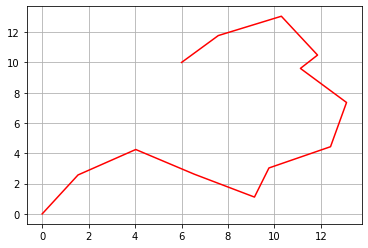

In [ ]:
# No Path Smoothing

# ====Search Path with RRT====
obstacleList = [(5, 5, 1), (3, 6, 2), (3, 8, 2), (3, 10, 2), (7, 5, 2),
                (9, 5, 2), (8, 10, 1)]  # [x, y, radius]
# Set Initial parameters
rrt = RRT(
    start=[0, 0],
    goal=[6, 10],
    rand_area=[-2, 15],
    obstacle_list=obstacleList)
path = rrt.planning(animation=show_animation)

if path is None:
    print("Cannot find path")
else:
    print("found path!!")

    # Draw final path
    if show_animation:
        rrt.draw_graph()
        plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
        plt.grid(True)
        plt.pause(0.01)  # Need for Mac
        plt.show()


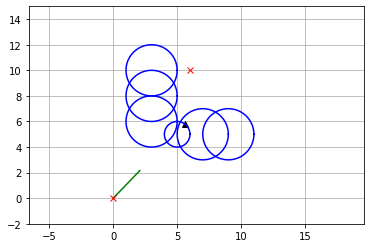

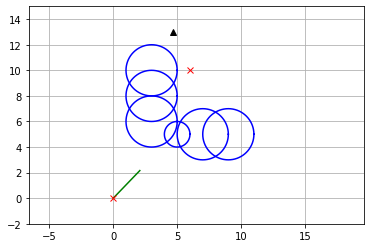

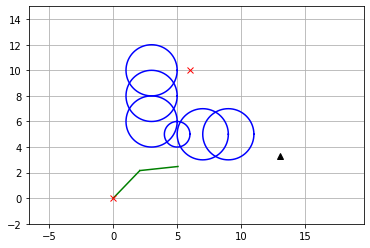

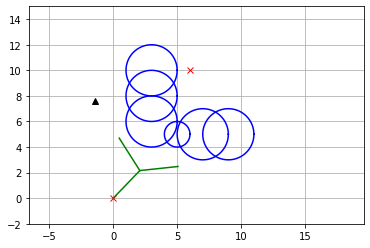

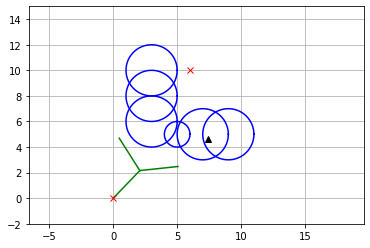

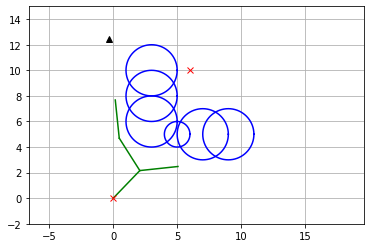

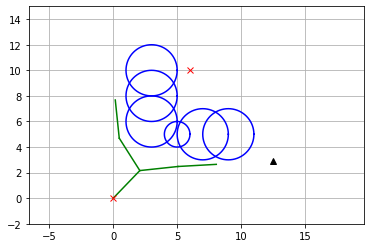

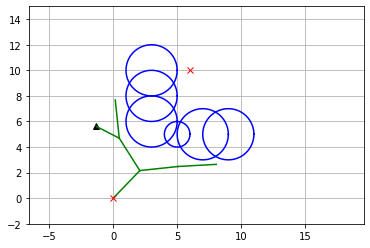

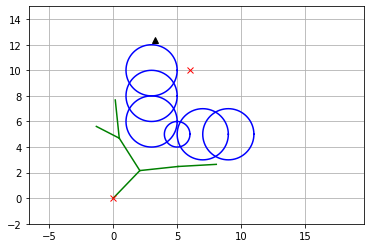

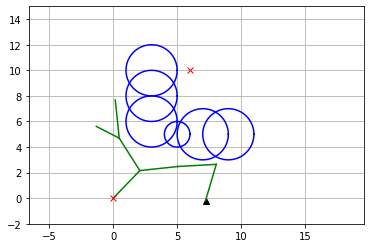

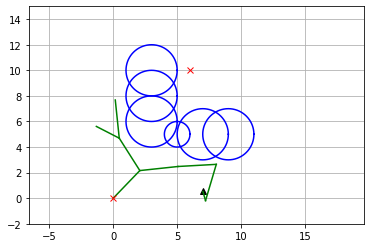

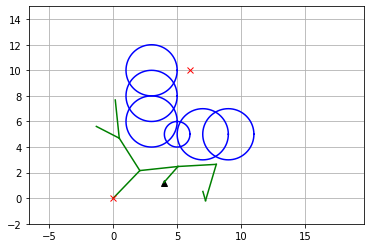

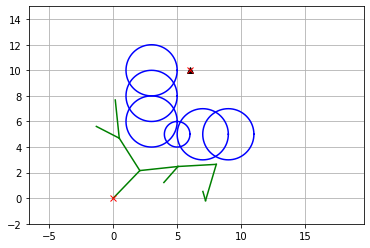

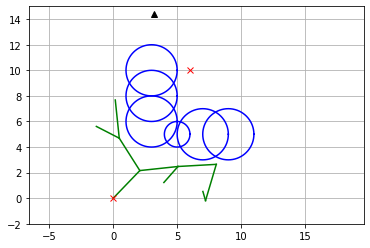

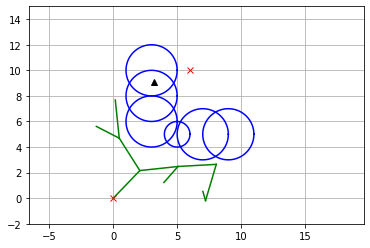

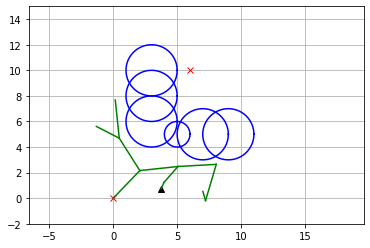

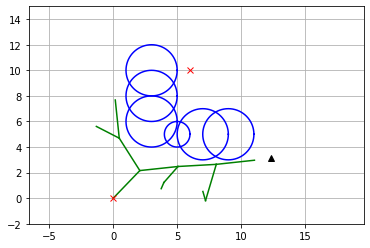

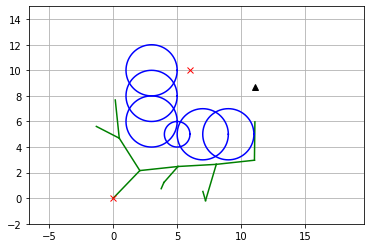

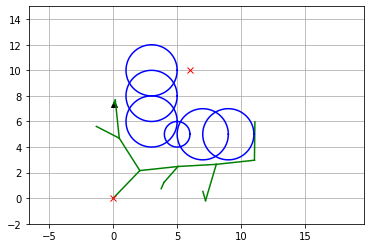

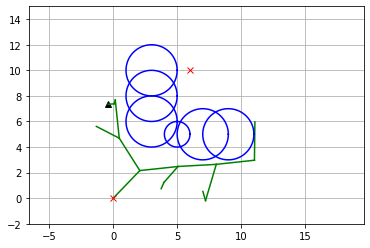

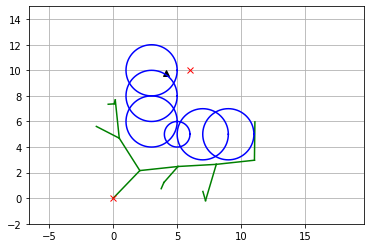

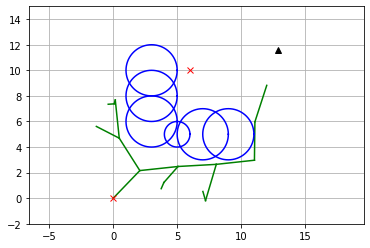

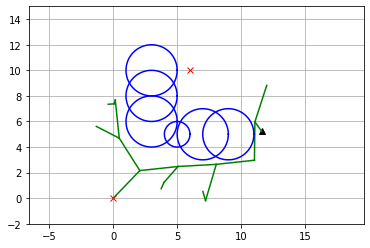

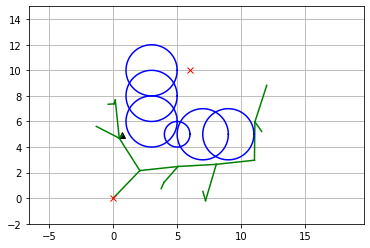

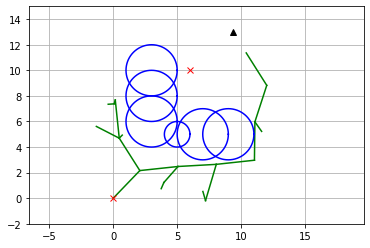

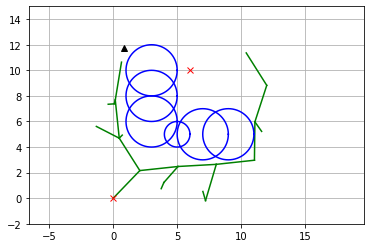

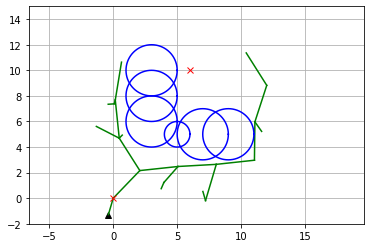

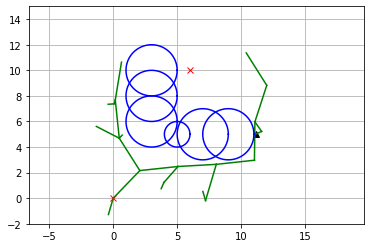

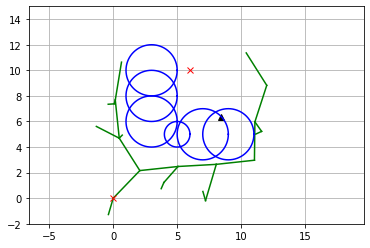

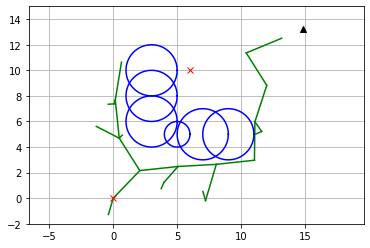

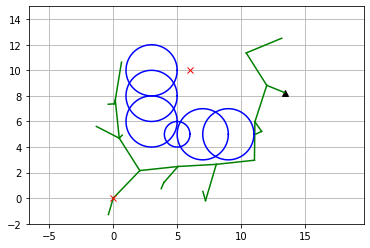

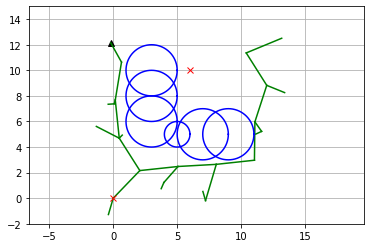

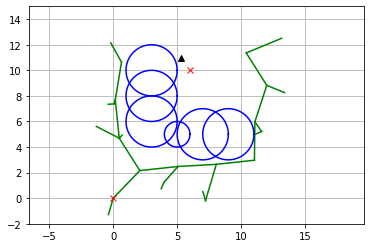

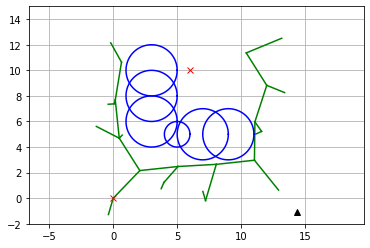

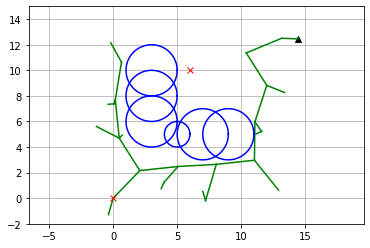

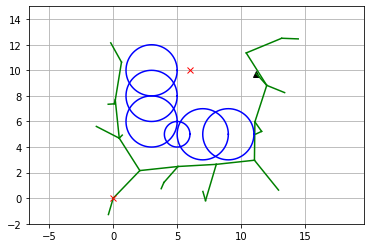

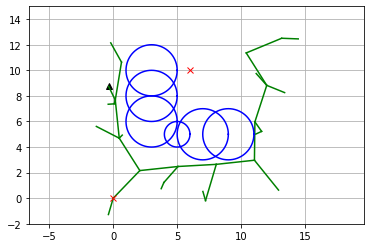

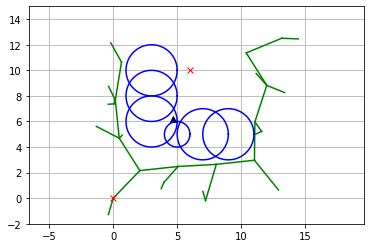

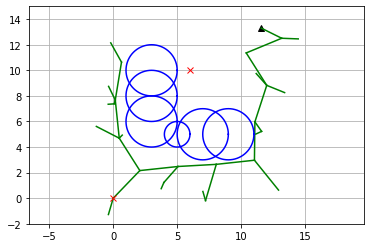

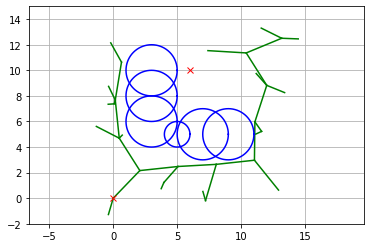

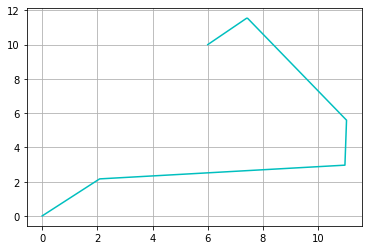

In [ ]:
# Path smoothing

# ====Search Path with RRT====
# Parameter
obstacleList = [
    (5, 5, 1),
    (3, 6, 2),
    (3, 8, 2),
    (3, 10, 2),
    (7, 5, 2),
    (9, 5, 2)
] 
rrt = RRT(start=[0, 0], goal=[6, 10],
          rand_area=[-2, 15], obstacle_list=obstacleList)
path = rrt.planning(animation=show_animation)

# Path smoothing
maxIter = 100000
smoothedPath = path_smoothing(path, maxIter, obstacleList)

# Draw final path
if show_animation:
    rrt.draw_graph()
    # plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')

    plt.plot([x for (x, y) in smoothedPath], [
        y for (x, y) in smoothedPath], '-c')

    plt.grid(True)
    plt.pause(0.01)  # Need for Mac
    plt.show()

Iter: 0 , number of nodes: 1


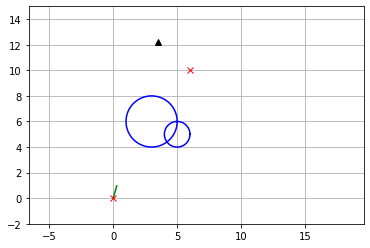

Iter: 1 , number of nodes: 2


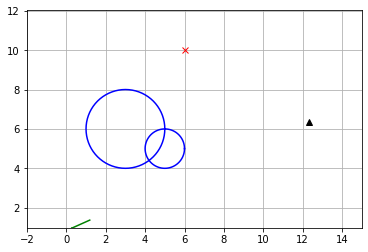

Iter: 2 , number of nodes: 3


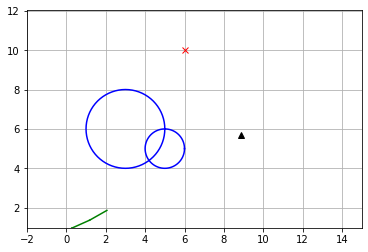

Iter: 3 , number of nodes: 4


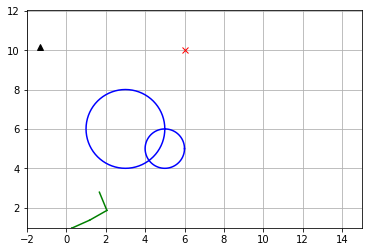

Iter: 4 , number of nodes: 5


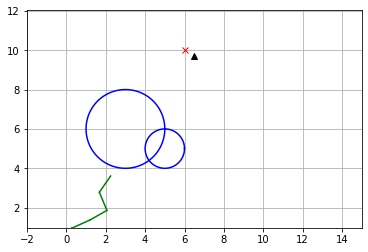

Iter: 5 , number of nodes: 6


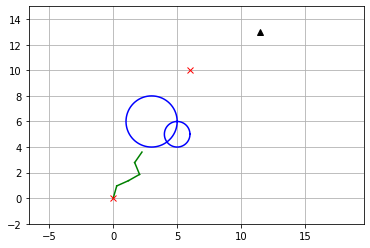

Iter: 6 , number of nodes: 6


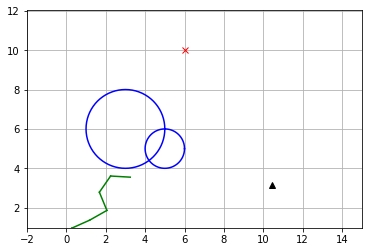

Iter: 7 , number of nodes: 7


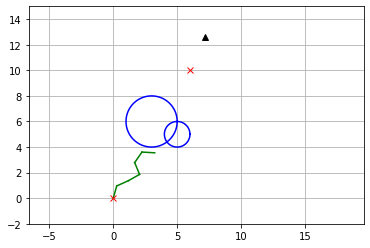

Iter: 8 , number of nodes: 7


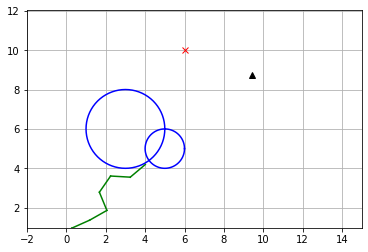

Iter: 9 , number of nodes: 8


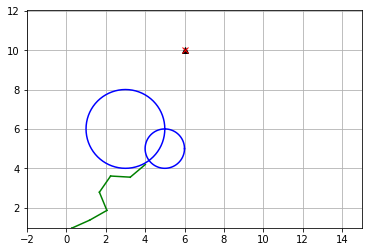

Iter: 10 , number of nodes: 8


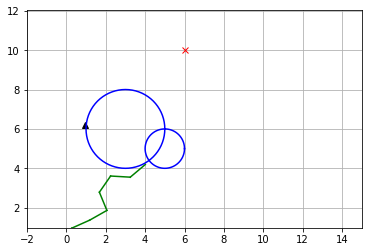

Iter: 11 , number of nodes: 8


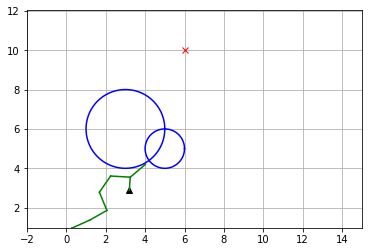

Iter: 12 , number of nodes: 9


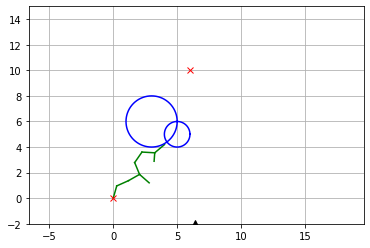

Iter: 13 , number of nodes: 10


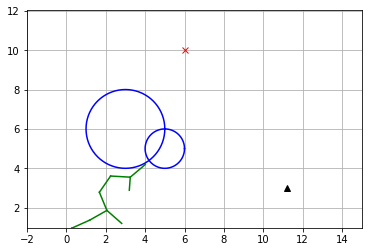

Iter: 14 , number of nodes: 10


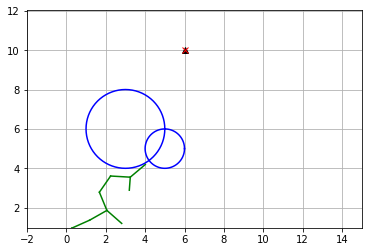

Iter: 15 , number of nodes: 10


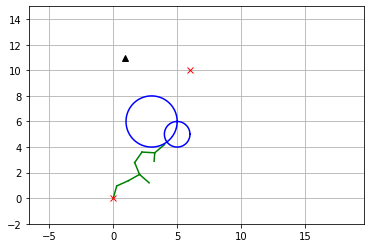

Iter: 16 , number of nodes: 10


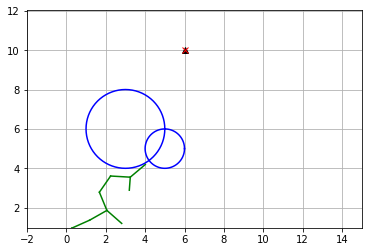

Iter: 17 , number of nodes: 10


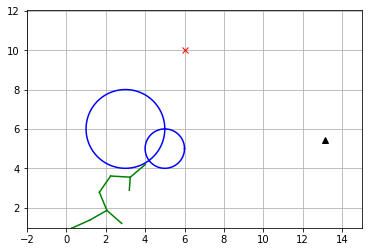

Iter: 18 , number of nodes: 10


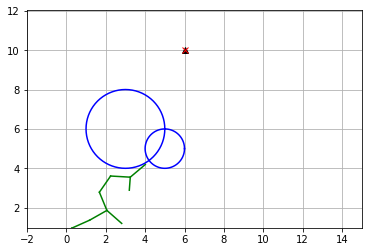

Iter: 19 , number of nodes: 10


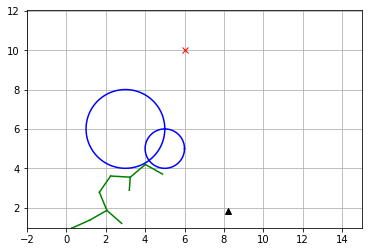

Iter: 20 , number of nodes: 11


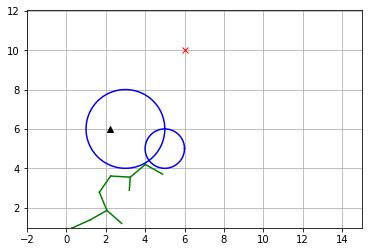

Iter: 21 , number of nodes: 11


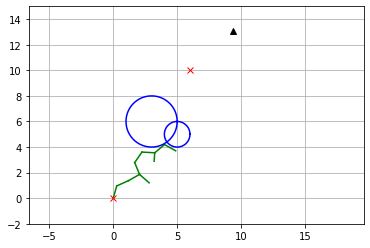

Iter: 22 , number of nodes: 11


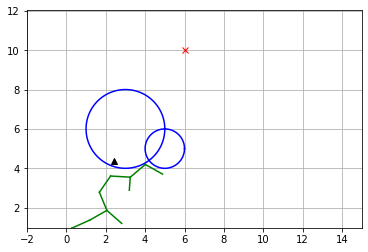

Iter: 23 , number of nodes: 11


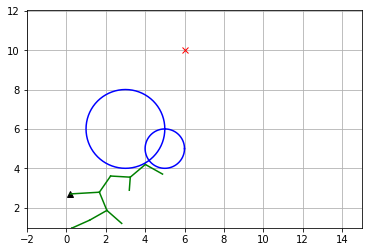

Iter: 24 , number of nodes: 12


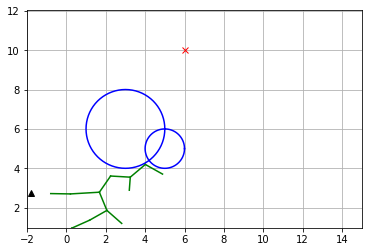

Iter: 25 , number of nodes: 13


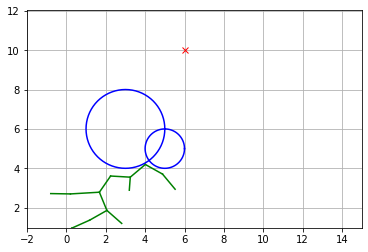

Iter: 26 , number of nodes: 14


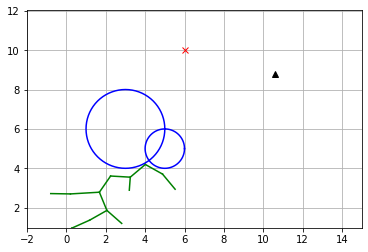

Iter: 27 , number of nodes: 14


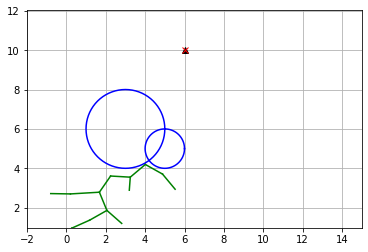

Iter: 28 , number of nodes: 14


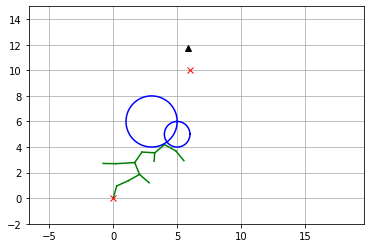

Iter: 29 , number of nodes: 14


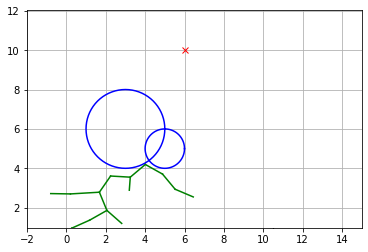

Iter: 30 , number of nodes: 15


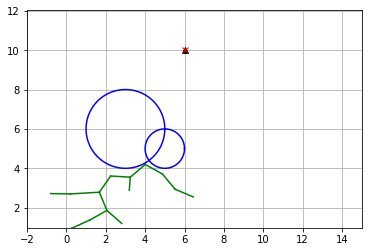

Iter: 31 , number of nodes: 15


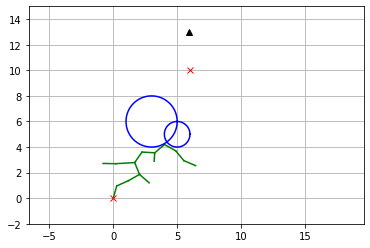

Iter: 32 , number of nodes: 15


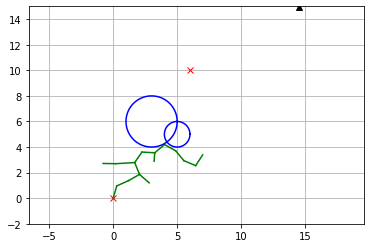

Iter: 33 , number of nodes: 16


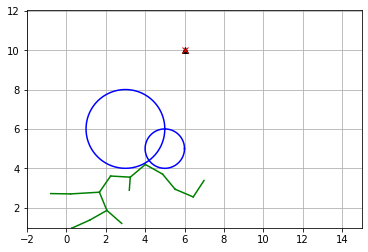

Iter: 34 , number of nodes: 16


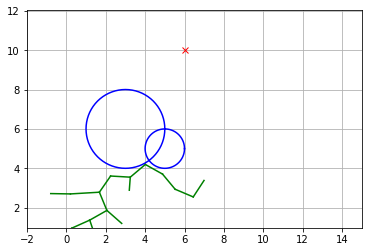

Iter: 35 , number of nodes: 17


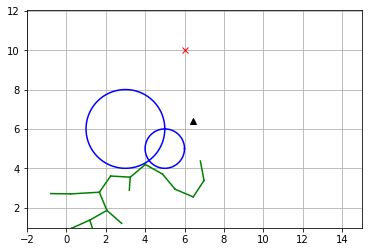

Iter: 36 , number of nodes: 18


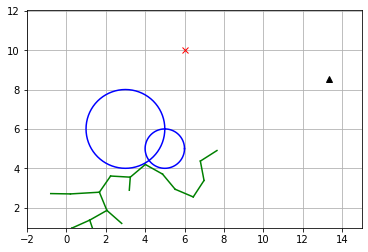

Iter: 37 , number of nodes: 19


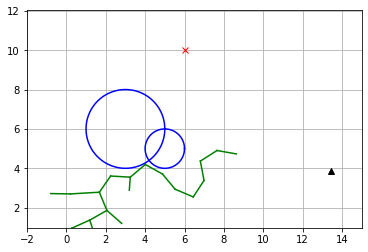

Iter: 38 , number of nodes: 20


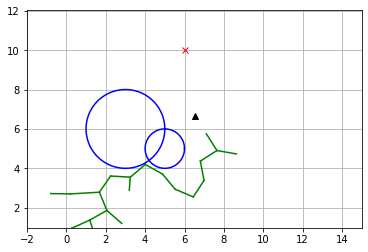

Iter: 39 , number of nodes: 21


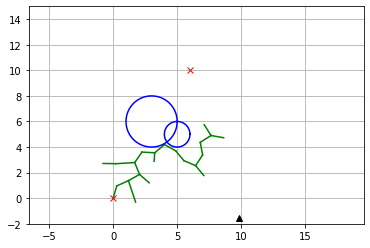

Iter: 40 , number of nodes: 22


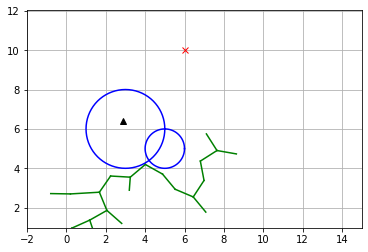

Iter: 41 , number of nodes: 22


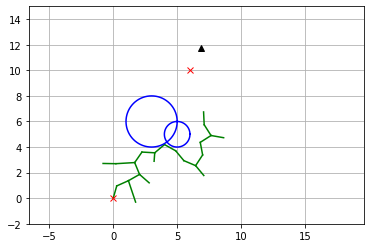

Iter: 42 , number of nodes: 23


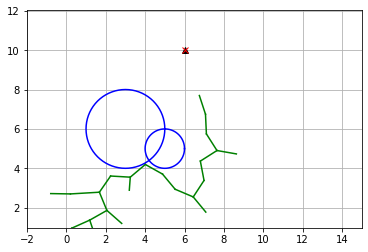

Iter: 43 , number of nodes: 24


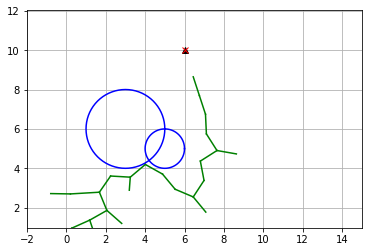

Iter: 44 , number of nodes: 25


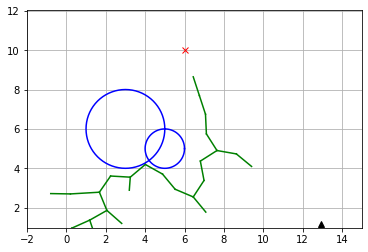

Iter: 45 , number of nodes: 26


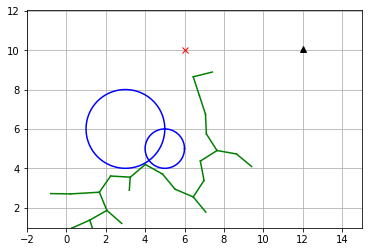

Iter: 46 , number of nodes: 27


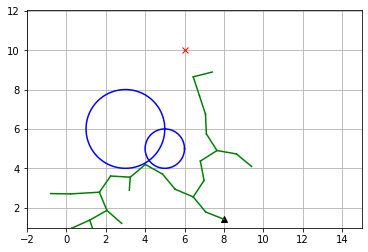

Iter: 47 , number of nodes: 28


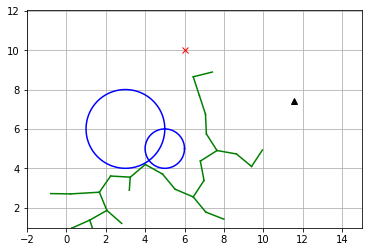

Iter: 48 , number of nodes: 29


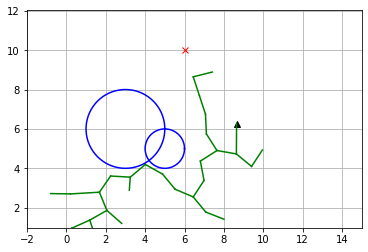

Iter: 49 , number of nodes: 30


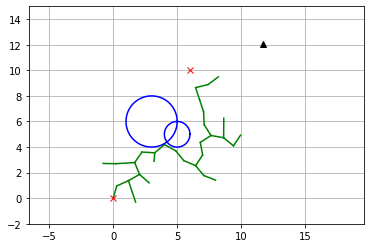

Iter: 50 , number of nodes: 31


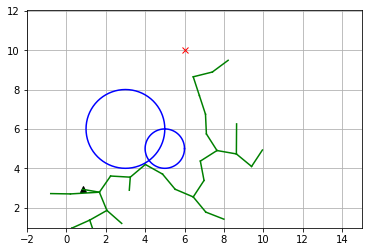

Iter: 51 , number of nodes: 32


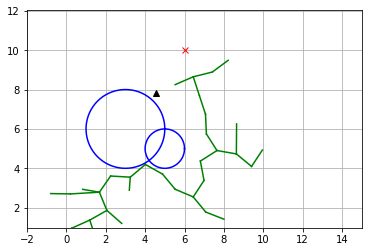

Iter: 52 , number of nodes: 33


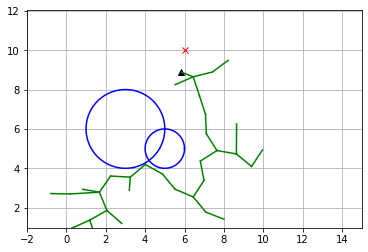

Iter: 53 , number of nodes: 34


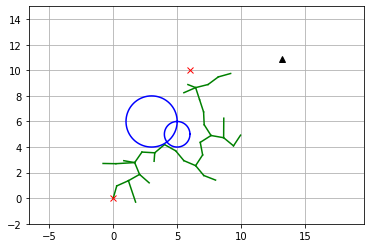

Iter: 54 , number of nodes: 35


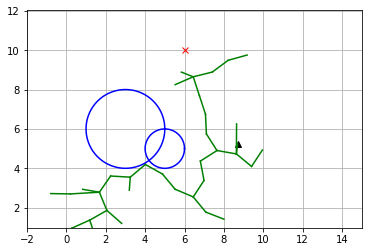

Iter: 55 , number of nodes: 36


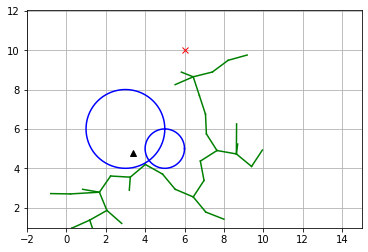

Iter: 56 , number of nodes: 36


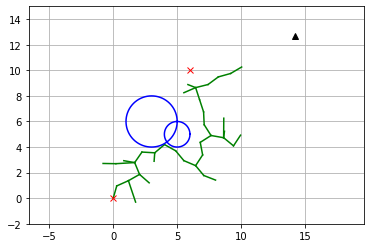

Iter: 57 , number of nodes: 37


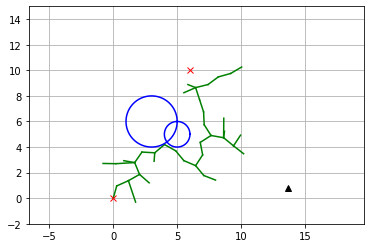

Iter: 58 , number of nodes: 38


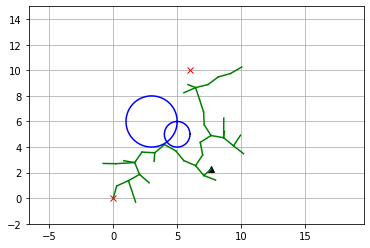

Iter: 59 , number of nodes: 39


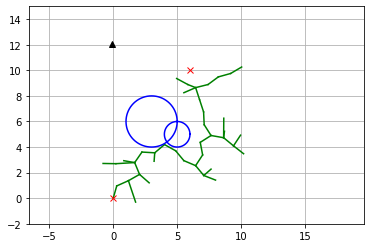

Iter: 60 , number of nodes: 40


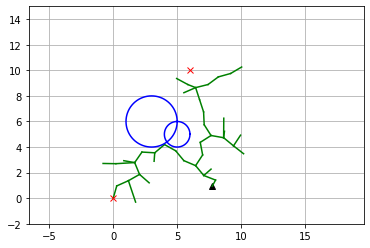

Iter: 61 , number of nodes: 41


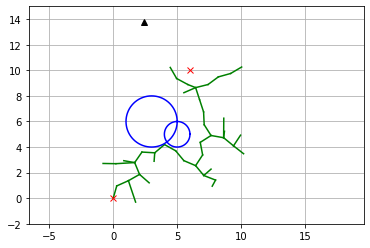

Iter: 62 , number of nodes: 42


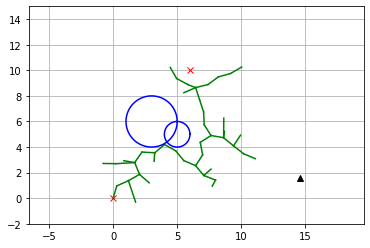

Iter: 63 , number of nodes: 43


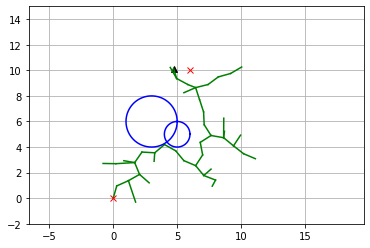

Iter: 64 , number of nodes: 44


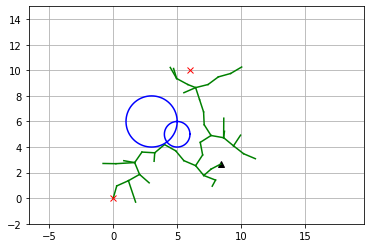

Iter: 65 , number of nodes: 45


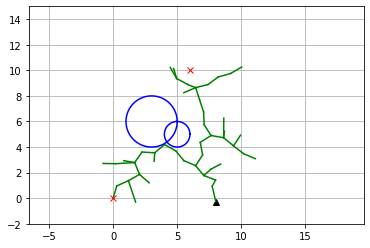

Iter: 66 , number of nodes: 46


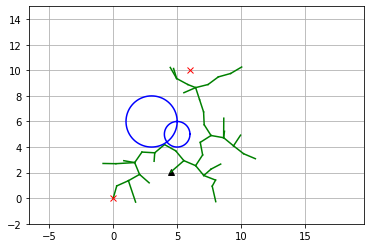

Iter: 67 , number of nodes: 47


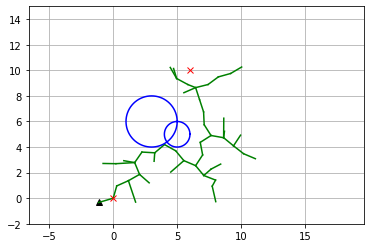

Iter: 68 , number of nodes: 48


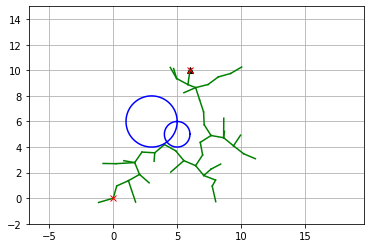

found path!!


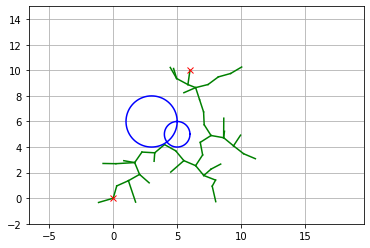

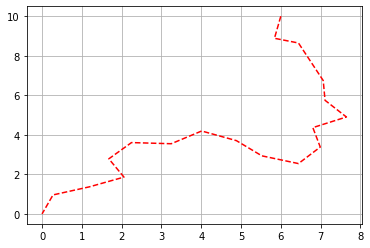

In [ ]:
# RRT*

# ====Search Path with RRT====
obstacle_list = [
    (5, 5, 1),
    (3, 6, 2),
    # (3, 8, 2),
    # (3, 10, 2),
    # (7, 5, 2),
    # (9, 5, 2),
    # (8, 10, 1),
    # (6, 12, 1),
]  # [x,y,size(radius)]

# Set Initial parameters
rrt_star = RRTStar(
    start=[0, 0],
    goal=[6, 10],
    max_iter=500,
    rand_area=[-2, 15],
    obstacle_list=obstacle_list,
    expand_dis=1)
path = rrt_star.planning(animation=show_animation)

if path is None:
    print("Cannot find path")
else:
    print("found path!!")

    # Draw final path
    if show_animation:
        rrt_star.draw_graph()
        plt.plot([x for (x, y) in path], [y for (x, y) in path], 'r--')
        plt.grid(True)
plt.show()


In [ ]:
path

[[6, 10],
 [6, 10],
 [5.840410859808383, 8.884757699611075],
 [6.443312245089901, 8.646490380544398],
 [6.75457038578519, 7.696164978457874],
 [7.0658285264804785, 6.745839576371351],
 [7.111685029054889, 5.746891539098319],
 [7.6484848530555825, 4.903181903647339],
 [6.80500046950218, 4.366028206181207],
 [6.99134166030376, 3.3835431118359294],
 [6.443859300502494, 2.5467258882402173],
 [5.523566147318, 2.9379553761392536],
 [4.8843123902924965, 3.706951237070103],
 [4.011229556668078, 4.1945231452337675],
 [3.2462417754578725, 3.550478352848108],
 [2.2479321315180494, 3.6085976681980294],
 [1.6781693756733267, 2.786788443345797],
 [2.059025326957292, 1.8621540591854489],
 [1.1887578123043232, 1.3695746717363348],
 [0.2759568200006043, 0.961170033602356],
 [0, 0]]

In [ ]:
class RRT_closest(RRT):
    """
    RRT except returns closest path instead of None
    """

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=3.0,
                 path_resolution=.5,
                 goal_sample_rate=5,
                 max_iter=5,
                 obj_reached=False):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []
        self.obj_reached = obj_reached
    
    """ 
    Necessary function because RRT.planning() will 
    always return a path, even if not to the goal
    """
    def goal_reached(self):
        return self.obj_reached


    def planning(self, animation=True):
        """
        rrt path planning
        animation: flag for animation on or off
        """

        """ added """
        best_ind = 0
        best_node = self.start

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_collision(new_node, self.obstacle_list):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            """ distance between new_node and goal """
            new_dist = self.calc_dist_to_goal(self.node_list[-1].x, self.node_list[-1].y)
            if  new_dist <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(final_node, self.obstacle_list):
                    self.obj_reached = True
                    return self.generate_final_course(len(self.node_list) - 1)

            """ update best_node """
            if new_dist <= self.calc_dist_to_goal(best_node.x, best_node.y):
                best_ind = len(self.node_list) - 1
                best_node = new_node

            if animation and i % 5:
                self.draw_graph(rnd_node)

        """ generate path from best_node to start_node """
        return self.generate_course(best_ind)

    def generate_course(self, goal_ind):
        node = self.node_list[goal_ind]
        path = []
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def get_path_length(path):
        le = 0
        for i in range(len(path) - 1):
            dx = path[i + 1][0] - path[i][0]
            dy = path[i + 1][1] - path[i][1]
            d = math.sqrt(dx * dx + dy * dy)
            le += d

        return le


    def get_target_point(path, targetL):
        le = 0
        ti = 0
        lastPairLen = 0
        for i in range(len(path) - 1):
            dx = path[i + 1][0] - path[i][0]
            dy = path[i + 1][1] - path[i][1]
            d = math.sqrt(dx * dx + dy * dy)
            le += d
            if le >= targetL:
                ti = i - 1
                lastPairLen = d
                break

        partRatio = (le - targetL) / lastPairLen

        x = path[ti][0] + (path[ti + 1][0] - path[ti][0]) * partRatio
        y = path[ti][1] + (path[ti + 1][1] - path[ti][1]) * partRatio

        return [x, y, ti]


    def line_collision_check(first, second, obstacleList):
        # Line Equation

        x1 = first[0]
        y1 = first[1]
        x2 = second[0]
        y2 = second[1]

        try:
            a = y2 - y1
            b = -(x2 - x1)
            c = y2 * (x2 - x1) - x2 * (y2 - y1)
        except ZeroDivisionError:
            return False

        for (ox, oy, size) in obstacleList:
            d = abs(a * ox + b * oy + c) / (math.sqrt(a * a + b * b))
            if d <= size:
                return False

        return True  # OK


    def path_smoothing(path, max_iter, obstacle_list):
        le = get_path_length(path)

        for i in range(max_iter):
            # Sample two points
            pickPoints = [random.uniform(0, le), random.uniform(0, le)]
            pickPoints.sort()
            first = get_target_point(path, pickPoints[0])
            second = get_target_point(path, pickPoints[1])

            if first[2] <= 0 or second[2] <= 0:
                continue

            if (second[2] + 1) > len(path):
                continue

            if second[2] == first[2]:
                continue

            # collision check
            if not line_collision_check(first, second, obstacle_list):
                continue

            # Create New path
            newPath = []
            newPath.extend(path[:first[2] + 1])
            newPath.append([first[0], first[1]])
            newPath.append([second[0], second[1]])
            newPath.extend(path[second[2] + 1:])
            path = newPath
            le = get_path_length(path)

        return path

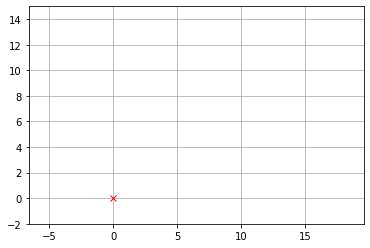

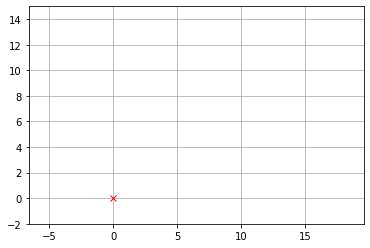

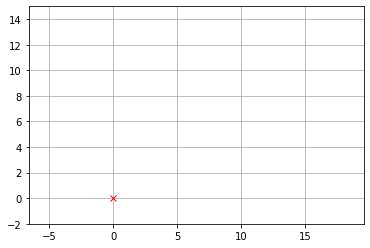

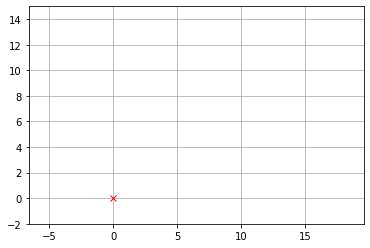

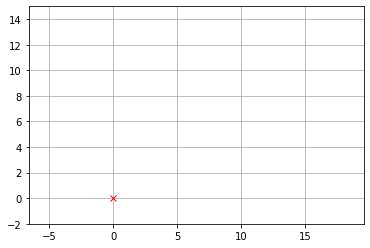

found path!!
[[-891.2051812625577, 128.6961907335926], [-941.1865413837631, 127.33103856850192], [-986.3772855136631, 105.93485561484329], [-1036.1159819080058, 111.03995904097246], [-1085.6438790711536, 117.89469481974606], [-1100, 70]]


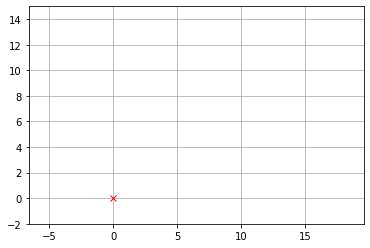

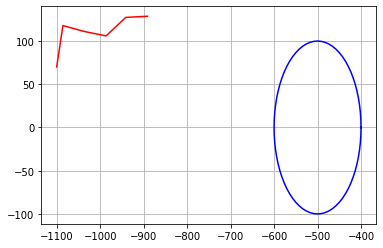

In [ ]:
# No Path Smoothing

# ====Search Path with RRT====
# obstacleList = [(5, 5, 1), (3, 6, 2), (3, 8, 2), (3, 10, 2), (7, 5, 2),
#                 (9, 5, 2), (8, 10, 1)]  # [x, y, radius](-300, 450, 100)
def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

obstacleList = [(-500, 0, 100)]
# Set Initial parameters
rrt = RRT_closest(
    expand_dis = 50.0,
    start=[-1100, 70],
    goal=[0, 0],
    rand_area=[-1100, 1100],
    obstacle_list=obstacleList, max_iter= 5)
path = rrt.planning(animation=True)

if path is None:
    print("Cannot find path")
else:
    print("found path!!")
    print(path)
    # Draw final path
    if show_animation:
        rrt.draw_graph()
        plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
        for o in obstacleList:
          plot_circle(o[0], o[1], o[2])
        plt.grid(True)
        plt.pause(0.01)  # Need for Mac
        plt.show()
